# PART II
The purpose of this document is to split the forcing data and the velocity results for a single member. First, we load in the relevant libraries and packages.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

2022-11-28 16:44:13.574033: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [33]:
def prepare_y(data_sets,time_reindex=True):
    if isinstance(data_sets, str):
        data_sets = [data_sets]
        
    Y_all = []
    length_all = []
    
    for file in data_sets:
        data_raw = xr.open_dataset(f"raw_data/velsurf_{file}_100yr_d1.nc",decode_times=False)
        data = data_raw.isel(time=np.arange(1000,len(data_raw.time),1)).drop(['lon','lat'])
        Y_all.append(data)
        length_all.append(len(data.time))
    
    length_all = np.array(length_all)
    Y = xr.concat(Y_all,dim='time')
    # Y = xr.concat([xr.open_dataset(data_path + f"outputs_{file}.nc") for file in data_sets], dim='time').mean("member")
    Y = Y.transpose('time','x', 'y')
    if time_reindex:
        Y = Y.assign_coords(time=np.arange(len(Y.time)))
    
    return Y, length_all

def prepare_x(data_sets,time_range,time_reindex=True):
    if isinstance(data_sets, str):
        data_sets = [data_sets]
        
    X_all      = []
    length_all = []
    value_dict = {'240':1e20, '241':5e20, '242':2.5e21, '243':1e22}
    for file in data_sets:
        data_raw = xr.open_dataset(f'raw_data/ts_{file}_100yr_d1.nc',decode_times=False)
        data = data_raw.interp(time=time_range)
        data['param'] = (['time'],value_dict[file]*np.ones(len(time_range)))
        X_all.append(data)
        length_all.append(len(data.time))
    
    X = xr.concat(X_all,dim='time')
    length_all = np.array(length_all)
    # X = xr.concat([xr.open_dataset(data_path + f"inputs_{file}.nc") for file in data_sets], dim='time')
    if time_reindex:
        X = X.assign_coords(time=np.arange(len(X.time)))

    return X, length_all

In [34]:
y_train_xr,y_length = prepare_y(['240','242','243'])
y_test_xr,_ = prepare_y(['241'],time_reindex=False)
y_test_xr['time'] = y_test_xr.time
year_range = y_test_xr.time

X_train_xr,X_length = prepare_x(['240','242','243'],year_range)
X_test_xr,_ = prepare_x(['241'],year_range,time_reindex=False)

In [18]:
y_train_np = y_train_xr['velsurf_mag'].fillna(-1).data
y_test_np  = y_test_xr['velsurf_mag'].fillna(-1).data

In [19]:
# Compute mean/std of each variable for the whole dataset
meanstd_inputs = {}
predictors     = ['ice_surface_temp','param']
for var in predictors:
    meanstd_inputs[var] = (X_train_xr[var].data.mean(),X_train_xr[var].data.std())
    
# normalize each variables
for var in predictors:
    # training set
    var_dims   = X_train_xr[var].dims
    X_train_xr = X_train_xr.assign({var: (var_dims, normalize(X_train_xr[var].data, var, meanstd_inputs))})
    
    # test set
    var_dims  = X_test_xr[var].dims
    X_test_xr = X_test_xr.assign({var: (var_dims, normalize(X_test_xr[var].data, var, meanstd_inputs))})

In [20]:
X_train_np = X_train_xr.to_array().transpose('time', 'x', 'y', 'variable').data
X_test_np  = X_test_xr.to_array().transpose('time', 'x', 'y', 'variable').data

print(X_train_np.shape,y_train_np.shape,X_test_np.shape,y_test_np.shape)

(756, 381, 381, 2) (756, 381, 381) (252, 381, 381, 2) (252, 381, 381)


In [21]:
start = np.cumsum(X_length) - X_length
end   = np.cumsum(X_length)

slider = 2
n_samples   = X_train_np.shape[0] - (slider-1)*len(X_length)
n_lat,n_lon,n_feature = X_train_np.shape[1:]

X_train = np.zeros([n_samples,slider,n_lat,n_lon,n_feature])
y_train = np.zeros([n_samples,1,n_lat,n_lon])

n_start = 0
for i in range(len(X_length)):
    
    X_subset = X_train_np[start[i]:end[i],:]
    y_subset = y_train_np[start[i]:end[i],:]
    
    X_subset = np.array([X_subset[i:i+slider] for i in range(0, X_length[i]-slider+1)])
    y_subset = np.array([[y_subset[i+slider-1]] for i in range(0, X_length[i]-slider+1)])
    
    # print(X_subset.shape,y_subset.shape)
    n_length = X_subset.shape[0]
    X_train[n_start:n_start+n_length,:,:,:,:] = X_subset
    y_train[n_start:n_start+n_length,:,:,:]   = y_subset
    n_start += n_length
    
X_test  = np.array([X_test_np[i:i+slider] for i in range(0, X_test_np.shape[0]-slider+1)])


In [22]:
print(X_train.shape,y_train.shape,X_test.shape)

(753, 2, 381, 381, 2) (753, 1, 381, 381) (251, 2, 381, 381, 2)


In [23]:
from tensorflow.keras import backend as K

def custom_rmse(y_true, y_pred):
    y_pred = y_pred[y_true >=0]
    y_true = y_true[y_true >=0]
    
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)

    return K.sqrt(K.mean(tf.math.squared_difference(y_pred, y_true),axis= -1))

In [24]:
n_filters   = 32 # number of filters
kernel_size = 5  # kernel size for Covolutional layers
pool_size   = 2  # size for average pooling layers
n_lstm_unit = 15 # number of LSTM units
activation  = 'relu' # activation function
learning_rate = 0.001 # learning rate
minibatch_size = 8   # batch size
num_epochs     = 50   # number of total epochs

In [25]:
model = Sequential()

model.add(Input(shape=(slider, n_lat,n_lon,n_feature)))
model.add(TimeDistributed(Conv2D(n_filters, (kernel_size, kernel_size), 
                                     padding='same', activation=activation), input_shape=(slider, n_lat,n_lon,n_feature)))
model.add(TimeDistributed(AveragePooling2D(pool_size)))
model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(LSTM(n_lstm_unit, activation=activation))
model.add(Dense(n_lat*n_lon))
model.add(Activation('linear'))
model.add(Reshape((1, n_lat, n_lon)))


model.compile(loss=custom_rmse,optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 2, 381, 381, 32)  1632      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 2, 190, 190, 32)  0         
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 2, 32)            0         
 tributed)                                                       
                                                                 
 lstm_1 (LSTM)               (None, 15)                2880      
                                                                 
 dense_1 (Dense)             (None, 145161)            2322576   
                                                      

In [26]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(X_train, y_train, 
                    batch_size = minibatch_size,
                    epochs = num_epochs,
                    validation_split=0.2, verbose=1,
                    callbacks=[early_stop])

2022-11-28 16:48:48.032328: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1398190752 exceeds 10% of free system memory.
2022-11-28 16:48:50.031684: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1398190752 exceeds 10% of free system memory.


Epoch 1/50
76/76 [==============================] - 6s 60ms/step - loss: 229.8574 - val_loss: 313.9563
Epoch 2/50
76/76 [==============================] - 3s 43ms/step - loss: 203.1926 - val_loss: 294.6151
Epoch 3/50
76/76 [==============================] - 3s 43ms/step - loss: 169.2875 - val_loss: 272.7029
Epoch 4/50
76/76 [==============================] - 3s 43ms/step - loss: 162.2763 - val_loss: 251.9555
Epoch 5/50
76/76 [==============================] - 3s 43ms/step - loss: 157.3036 - val_loss: 235.6452
Epoch 6/50
76/76 [==============================] - 3s 44ms/step - loss: 154.7444 - val_loss: 221.1326
Epoch 7/50
76/76 [==============================] - 3s 43ms/step - loss: 150.1306 - val_loss: 211.1568
Epoch 8/50
76/76 [==============================] - 3s 44ms/step - loss: 147.0132 - val_loss: 204.9213
Epoch 9/50
76/76 [==============================] - 3s 43ms/step - loss: 144.8458 - val_loss: 201.7327
Epoch 10/50
76/76 [==============================] - 3s 44ms/step - loss:

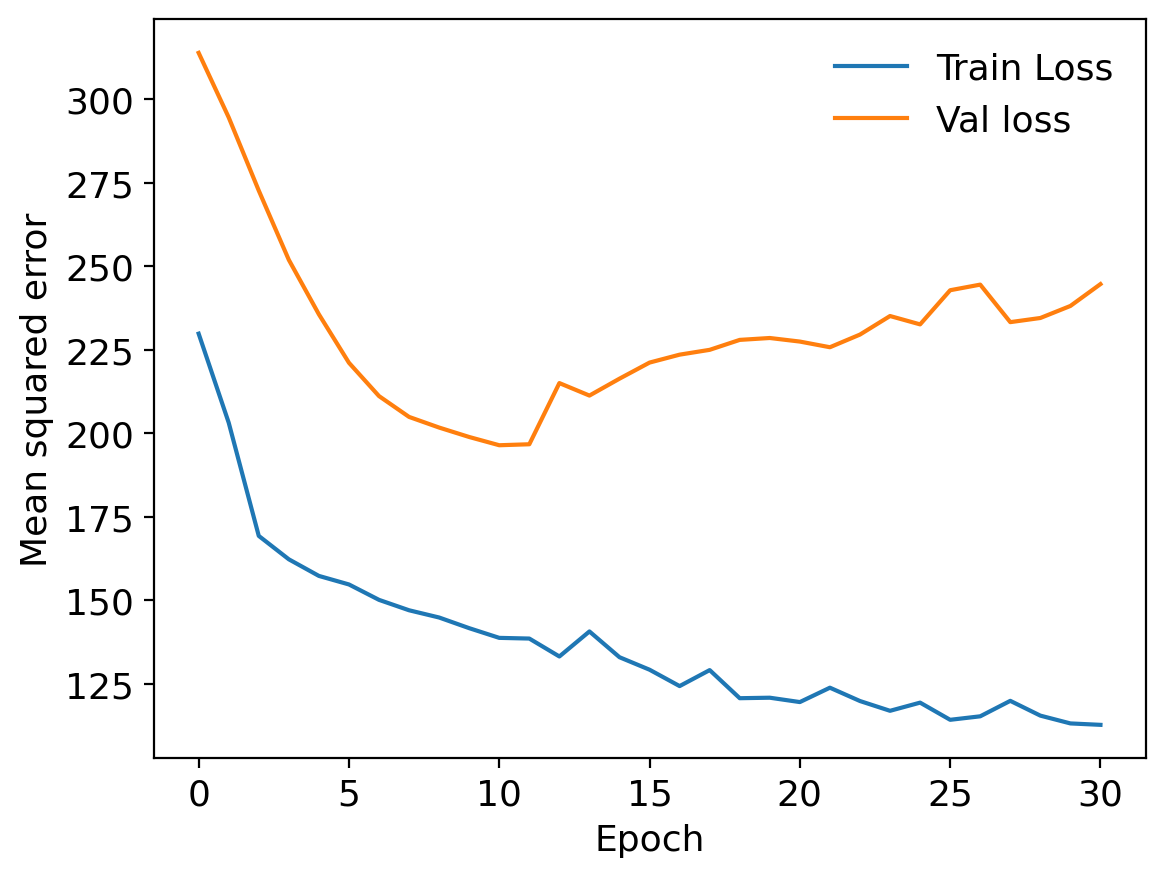

In [27]:
plot_history(history)

In [28]:
y_test_pre = model.predict(X_test)
y_test_pre = y_test_pre.reshape(y_test_pre.shape[0], 381, 381)
y_test_pre = xr.Dataset(coords={'time': X_test_xr.time.values[slider-1:], 
                               'x': X_test_xr.x.values, 
                               'y': X_test_xr.y.values},
                       data_vars=dict(velsurf_mag=(['time', 'y', 'x'], y_test_pre)))

8/8 [==============================] - 1s 46ms/step


In [29]:
y_test_pre = y_test_pre+y_test_xr-y_test_xr

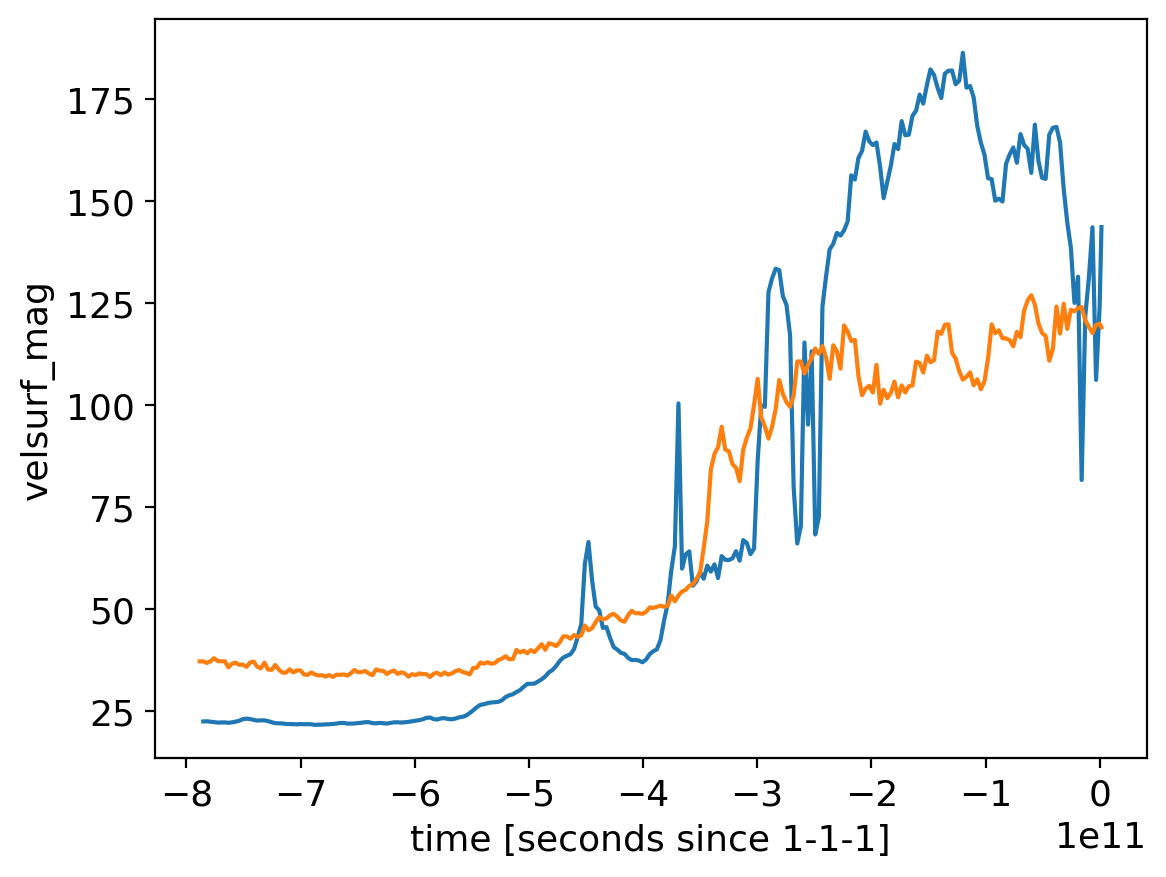

In [30]:
y_test_pre.velsurf_mag.mean(dim=['x','y']).plot()
y_test_xr.velsurf_mag.mean(dim=['x','y']).plot()